In [14]:
from openparticle.hamiltonians.yukawa_hamiltonians import yukawa_Hamiltonian
from openparticle import ParticleOperator
from openparticle.dlcq import momentum_states_partition
import numpy as np
import cirq
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.rescale import bosonically_rescale_terms, get_numbers_of_bosonic_operators_in_terms, get_number_of_active_bosonic_modes
from src.lobe.system import System
from src.lobe.lobe_circuit import lobe_circuit
from src.lobe.block_encoding import add_lobe_oracle
from colors import *

In [2]:
def generate_yukawa_circuit(res, max_bose_occ):

    operator = yukawa_Hamiltonian(res, 1, 1, 1)
    terms = operator.to_list()

    bosonically_rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(terms, max_bose_occ)
    coefficients = [term.coeff for term in bosonically_rescaled_terms]

    norm = sum(np.abs(coefficients))
    target_state = get_target_state(coefficients)
    asp_rescaling_factor = (bosonic_rescaling_factor * norm)

    number_of_modes = max([term.max_mode() for term in terms]) + 1

    number_of_ancillae = (
        1000  # Some arbitrary large number with most ancilla disregarded
    )
    number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
    number_of_rotation_qubits = max(get_number_of_active_bosonic_modes(terms)) + 1
    


    # Declare Qubits
    validation = cirq.LineQubit(0)
    clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
    rotation_qubits = [
        cirq.LineQubit(i + 1 + number_of_ancillae)
        for i in range(number_of_rotation_qubits)
    ]
    index_register = [
        cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits)
        for i in range(number_of_index_qubits)
    ]
    system = System(
        number_of_modes=number_of_modes,
        maximum_occupation_number=max_bose_occ,
        number_of_used_qubits=1
        + number_of_ancillae
        + number_of_rotation_qubits
        + number_of_index_qubits,
        has_fermions=operator.has_fermions,
        has_antifermions=operator.has_antifermions,
        has_bosons=operator.has_bosons,
    )

    #### ASP Circuit Generation
    ASP_numerics = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [1 + number_of_rotation_qubits - 1 + number_of_index_qubits],
        "angles": [],
        "number_of_nonclifford_rotations": 0,
        "rescaling_factor": asp_rescaling_factor,
        "number_of_modes": number_of_modes,
        "maximum_bosonic_occupation": max_bose_occ,
        "maximum_number_of_active_bosonic_modes": number_of_rotation_qubits - 1,
        "number_of_terms": len(terms)
    }
    circuit = cirq.Circuit()
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    circuit.append(cirq.X.on(validation))
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    circuit += add_lobe_oracle(
        bosonically_rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=False,
        numerics=ASP_numerics,
    )
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        dagger=True,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    ASP_numerics["number_of_ancillae"] = max(ASP_numerics["ancillae_tracker"])
    ASP_numerics["number_of_qubits"] = max(ASP_numerics["ancillae_tracker"]) + system.number_of_system_qubits
    for angle in ASP_numerics["angles"]:
        angle = np.abs(angle)
        if not np.isclose(angle%np.pi/4, 0):
            ASP_numerics["number_of_nonclifford_rotations"] += 1
    
    return {
        "ASP": ASP_numerics 
    }

In [3]:
from symmer import PauliwordOp

In [4]:
from time import time
fix_Omega = 3
res_max = 8
number_of_res_range = range(2, res_max)

DATA_FOR_FIXED_OMEGA = []
LCU_rots_DATA_FOR_FIXED_OMEGA = []
LCU_elbows_DATA_FOR_FIXED_OMEGA = []
for res in number_of_res_range:
    start = time()
    print("----{} of {}----".format(res, max(number_of_res_range)))
    DATA_FOR_FIXED_OMEGA.append(generate_yukawa_circuit(res, fix_Omega))
    LCU_rots_DATA_FOR_FIXED_OMEGA.append(2 * op_qubit_map(yukawa_Hamiltonian(res, 1, 1, 1), fix_Omega).n_terms)
    LCU_elbows_DATA_FOR_FIXED_OMEGA.append(op_qubit_map(yukawa_Hamiltonian(res, 1, 1, 1), fix_Omega).n_terms)
    print("* {} (s) *".format(round(time() - start, 1)))



----2 of 7----
* 0.2 (s) *
----3 of 7----
* 0.7 (s) *
----4 of 7----
* 2.7 (s) *
----5 of 7----
* 7.8 (s) *
----6 of 7----
* 21.7 (s) *
----7 of 7----
* 52.6 (s) *


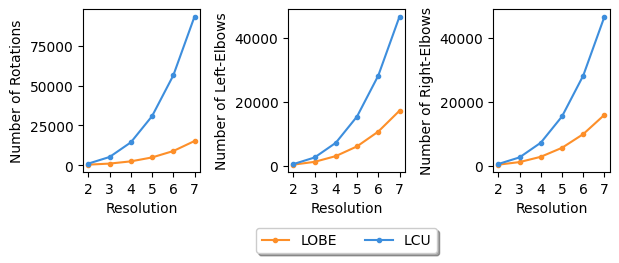

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16 / 2.54, 6 / 2.54))

numbers_of_terms_LOBE = [DATA_POINT["ASP"]["number_of_terms"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
resolutions = list(range(2, res_max))

left_elbows_asp = [DATA_POINT["ASP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
right_elbows_asp = [DATA_POINT["ASP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
rotations_asp = [DATA_POINT["ASP"]["rotations"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
nonclifford_rotations_asp = [DATA_POINT["ASP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# rescaling_factors_asp = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# numbers_of_qubits_asp = [DATA_POINT["ASP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# numbers_of_ancillae_asp = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]

# axes[0].plot(numbers_of_terms, rotations_usp, color=BLUE, marker='s', alpha = 1)
# axes[0].plot(numbers_of_terms, rotations_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].plot(resolutions, nonclifford_rotations_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].plot(resolutions, LCU_rots_DATA_FOR_FIXED_OMEGA, color=BLUE, marker='.', alpha = 1)
# axes[0].plot(numbers_of_terms, rotation_upper_bound, color=RED, ls='--', alpha = 1)
axes[0].set_ylabel("Number of Rotations")
# axes[0].set_xlabel("Number of Terms ($L$)")
axes[0].set_xlabel("Resolution")


axes[1].plot(resolutions, left_elbows_asp, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[1].plot(resolutions, LCU_elbows_DATA_FOR_FIXED_OMEGA, color=BLUE, marker='.', alpha = 1, label = 'LCU')
# axes[1].plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[1].set_ylabel("Number of Left-Elbows")
axes[1].set_xlabel("Resolution")

axes[2].plot(resolutions, right_elbows_asp, color=ORANGE, marker='.', alpha = 1)
axes[2].plot(resolutions, LCU_elbows_DATA_FOR_FIXED_OMEGA, color=BLUE, marker='.', alpha = 1)
# axes[2].plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[2].set_ylabel("Number of Right-Elbows")
axes[2].set_xlabel("Resolution")

plt.tight_layout()
# axes[0].set_yscale('log')
# axes[1].set_yscale('log')
# axes[2].set_yscale('log')
axes[0].set_xticks(resolutions)
axes[1].set_xticks(resolutions)
axes[2].set_xticks(resolutions)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=2)
plt.savefig("../manuscript/figures/yukawa_hamiltonian_gates_vs_resolution.pdf", dpi=600)

In [6]:
fix_res = 4

number_of_omega_range = [3, 7, 15, 31]

DATA_FOR_FIXED_RES = []
LCU_rots_DATA_FOR_FIXED_RES = []
LCU_elbows_DATA_FOR_FIXED_RES = []
for Omega in number_of_omega_range:
    start = time()
    print("----{} of {}----".format(Omega, max(number_of_omega_range)))
    DATA_FOR_FIXED_RES.append(generate_yukawa_circuit(fix_res, Omega))
    LCU_rots_DATA_FOR_FIXED_RES.append(2 * op_qubit_map(yukawa_Hamiltonian(fix_res, 1, 1, 1), Omega).n_terms)
    LCU_elbows_DATA_FOR_FIXED_RES.append(op_qubit_map(yukawa_Hamiltonian(fix_res, 1, 1, 1), Omega).n_terms)
    print("* {} (s) *".format(round(time() - start, 1)))

----3 of 31----
* 3.0 (s) *
----7 of 31----
* 6.2 (s) *
----15 of 31----
* 31.6 (s) *
----31 of 31----
* 202.9 (s) *


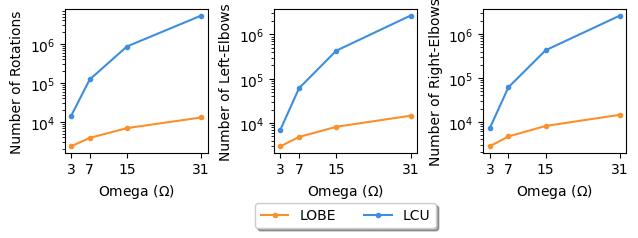

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16 / 2.54, 6 / 2.54))

omegas = number_of_omega_range

left_elbows_asp = [DATA_POINT["ASP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_RES]
right_elbows_asp = [DATA_POINT["ASP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_RES]
rotations_asp = [DATA_POINT["ASP"]["rotations"] for DATA_POINT in DATA_FOR_FIXED_RES]
nonclifford_rotations_asp = [DATA_POINT["ASP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_RES]
# rescaling_factors_asp = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# numbers_of_qubits_asp = [DATA_POINT["ASP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# numbers_of_ancillae_asp = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]

# axes[0].plot(numbers_of_terms, rotations_usp, color=BLUE, marker='s', alpha = 1)
# axes[0].plot(numbers_of_terms, rotations_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].plot(omegas, nonclifford_rotations_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].plot(omegas, LCU_rots_DATA_FOR_FIXED_RES, color=BLUE, marker='.', alpha = 1)
# axes[0].plot(numbers_of_terms, rotation_upper_bound, color=RED, ls='--', alpha = 1)
axes[0].set_ylabel("Number of Rotations")
# axes[0].set_xlabel("Number of Terms ($L$)")
axes[0].set_xlabel("Omega ($\Omega$)")


axes[1].plot(omegas, left_elbows_asp, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[1].plot(omegas, LCU_elbows_DATA_FOR_FIXED_RES, color=BLUE, marker='.', alpha = 1, label = 'LCU')
# axes[1].plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[1].set_ylabel("Number of Left-Elbows")
axes[1].set_xlabel("Omega ($\Omega$)")

axes[2].plot(omegas, right_elbows_asp, color=ORANGE, marker='.', alpha = 1)
axes[2].plot(omegas, LCU_elbows_DATA_FOR_FIXED_RES, color=BLUE, marker='.', alpha = 1)
# axes[2].plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[2].set_ylabel("Number of Right-Elbows")
axes[2].set_xlabel("Omega ($\Omega$)")

plt.tight_layout()
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[2].set_yscale('log')
axes[0].set_xticks(omegas)
axes[1].set_xticks(omegas)
axes[2].set_xticks(omegas)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=2)
plt.savefig("../manuscript/figures/yukawa_hamiltonian_gates_vs_omega.pdf", dpi=600)

In [8]:
numbers_of_ancillae_asp_fix_omega = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_OMEGA ]
rescaling_factors_asp_fix_omega = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_OMEGA ]

numbers_of_ancillae_LCU_fix_omega = [2 * np.log2(op_qubit_map(yukawa_Hamiltonian(res, 1, 1, 1), fix_Omega).n_terms) for res in number_of_res_range]
rescaling_factors_LCU_fix_omega = [np.linalg.norm((op_qubit_map(yukawa_Hamiltonian(res, 1, 1, 1), fix_Omega).coeff_vec), ord=1) for res in number_of_res_range]

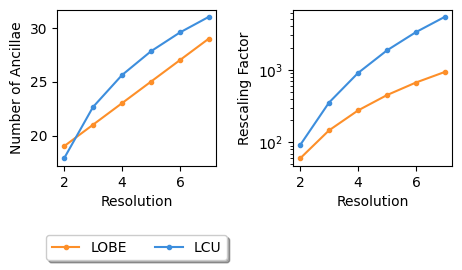

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12 / 2.54, 8 / 2.54))

axes[0].plot(number_of_res_range, numbers_of_ancillae_asp_fix_omega, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[0].plot(number_of_res_range, numbers_of_ancillae_LCU_fix_omega, color=BLUE, marker='.', alpha = 1, label = 'LCU')

axes[1].plot(number_of_res_range, rescaling_factors_asp_fix_omega, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[1].plot(number_of_res_range, rescaling_factors_LCU_fix_omega, color=BLUE, marker='.', alpha = 1, label = 'LCU')


axes[0].set_ylabel('Number of Ancillae')
axes[0].set_xlabel('Resolution')
axes[1].set_ylabel('Rescaling Factor')
axes[1].set_xlabel('Resolution')
axes[1].set_yscale('log')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("../manuscript/figures/yukawa_ancillae_vs_resolution.pdf", dpi=600)

In [10]:
numbers_of_ancillae_asp_fix_res = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_RES ]
rescaling_factors_asp_fix_res = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_RES ]

numbers_of_ancillae_LCU_fix_res = [np.log2(op_qubit_map(yukawa_Hamiltonian(fix_res, 1, 1, 1), Omega).n_terms) for Omega in number_of_omega_range]
rescaling_factors_LCU_fix_res = [np.linalg.norm((op_qubit_map(yukawa_Hamiltonian(fix_res, 1, 1, 1), Omega).coeff_vec), ord=1) for Omega in number_of_omega_range]

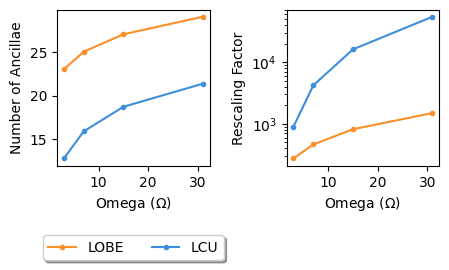

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12 / 2.54, 8 / 2.54))

axes[0].plot(number_of_omega_range, numbers_of_ancillae_asp_fix_res, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[0].plot(number_of_omega_range, numbers_of_ancillae_LCU_fix_res, color=BLUE, marker='.', alpha = 1, label = 'LCU')

axes[1].plot(number_of_omega_range, rescaling_factors_asp_fix_res, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[1].plot(number_of_omega_range, rescaling_factors_LCU_fix_res, color=BLUE, marker='.', alpha = 1, label = 'LCU')


axes[0].set_ylabel('Number of Ancillae')
axes[0].set_xlabel('Omega ($\Omega$)')
axes[1].set_ylabel('Rescaling Factor')
axes[1].set_xlabel('Omega ($\Omega$)')
axes[1].set_yscale('log')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("../manuscript/figures/yukawa_ancillae_vs_omega.pdf", dpi=600)

In [1]:
opdict = {((0, 3, 1), (1, 3, 1), (2, 3, 0), (2, 2, 0)): 0.012631288223382315,
 ((0, 3, 1), (1, 2, 1), (2, 3, 0), (2, 1, 0)): 0.013282740536920905,
 ((0, 3, 1), (1, 1, 1), (2, 3, 0), (2, 0, 0)): 0.009322861390548462,
 ((0, 3, 1), (0, 0, 0), (2, 0, 1), (2, 3, 0)): -0.0002752835077453211,
 ((0, 3, 1), (0, 1, 0), (2, 1, 1), (2, 3, 0)): -0.020247613335879024,
 ((0, 3, 1), (0, 2, 0), (2, 2, 1), (2, 3, 0)): -0.020742409268258717,
 ((0, 3, 1), (0, 3, 0), (2, 3, 1), (2, 3, 0)): -0.01854720857212109,
 ((0, 3, 1), (1, 3, 1), (2, 2, 0), (2, 3, 0)): -0.014947013833944946,
 ((0, 3, 1), (1, 2, 1), (2, 2, 0), (2, 2, 0)): -0.01246594301481967,
 ((0, 3, 1), (1, 1, 1), (2, 2, 0), (2, 1, 0)): -0.0075981794327065,
 ((0, 3, 1), (1, 0, 1), (2, 2, 0), (2, 0, 0)): -6.43901283960525e-06,
 ((0, 3, 1), (0, 1, 0), (2, 0, 1), (2, 2, 0)): 0.040476528940193435,
 ((0, 3, 1), (0, 2, 0), (2, 1, 1), (2, 2, 0)): 0.03471151351644862,
 ((0, 3, 1), (0, 3, 0), (2, 2, 1), (2, 2, 0)): 0.028570266464463184,
 ((0, 3, 1), (1, 2, 1), (2, 1, 0), (2, 3, 0)): -0.004424924261114065,
 ((0, 3, 1), (1, 1, 1), (2, 1, 0), (2, 2, 0)): -0.0025429087127192174,
 ((0, 3, 1), (1, 0, 1), (2, 1, 0), (2, 1, 0)): -1.9788066036718544e-05,
 ((0, 3, 1), (0, 0, 0), (2, 1, 0), (2, 0, 0)): 0.00019281138745354219,
 ((0, 3, 1), (0, 2, 0), (2, 0, 1), (2, 1, 0)): 0.024492215325329986,
 ((0, 3, 1), (0, 3, 0), (2, 1, 1), (2, 1, 0)): 0.016880075280371956,
 ((0, 3, 1), (1, 1, 1), (2, 0, 0), (2, 3, 0)): -0.001874476083813978,
 ((0, 3, 1), (1, 0, 1), (2, 0, 0), (2, 2, 0)): -4.564031547756816e-05,
 ((0, 3, 1), (0, 0, 0), (2, 0, 0), (2, 1, 0)): 0.0001720989308399029,
 ((0, 3, 1), (0, 1, 0), (2, 0, 0), (2, 0, 0)): 0.012625810237683896,
 ((0, 3, 1), (0, 3, 0), (2, 0, 1), (2, 0, 0)): 0.0247588139888685,
 ((0, 2, 1), (1, 3, 1), (2, 3, 0), (2, 1, 0)): 0.004424061044236262,
 ((0, 2, 1), (1, 2, 1), (2, 3, 0), (2, 0, 0)): 0.00485494827970955,
 ((0, 2, 1), (1, 0, 1), (2, 0, 1), (2, 3, 0)): 4.691488837617475e-05,
 ((0, 2, 1), (0, 0, 0), (2, 1, 1), (2, 3, 0)): -9.342289246813534e-05,
 ((0, 2, 1), (0, 1, 0), (2, 2, 1), (2, 3, 0)): -0.0049658701810101165,
 ((0, 2, 1), (0, 2, 0), (2, 3, 1), (2, 3, 0)): -0.0050984715732052535,
 ((0, 2, 1), (1, 3, 1), (2, 2, 0), (2, 2, 0)): 0.012468526507644427,
 ((0, 2, 1), (1, 2, 1), (2, 2, 0), (2, 1, 0)): 0.011178343902352391,
 ((0, 2, 1), (1, 1, 1), (2, 2, 0), (2, 0, 0)): 0.007434261836789085,
 ((0, 2, 1), (0, 0, 0), (2, 0, 1), (2, 2, 0)): -0.0007071005273075055,
 ((0, 2, 1), (0, 1, 0), (2, 1, 1), (2, 2, 0)): -0.025734901000552084,
 ((0, 2, 1), (0, 2, 0), (2, 2, 1), (2, 2, 0)): -0.024086006593353533,
 ((0, 2, 1), (0, 3, 0), (2, 3, 1), (2, 2, 0)): -0.020742694043892358,
 ((0, 2, 1), (1, 3, 1), (2, 1, 0), (2, 3, 0)): -0.01328083691722705,
 ((0, 2, 1), (1, 2, 1), (2, 1, 0), (2, 2, 0)): -0.01240567680627439,
 ((0, 2, 1), (1, 1, 1), (2, 1, 0), (2, 1, 0)): -0.006438413924137948,
 ((0, 2, 1), (1, 0, 1), (2, 1, 0), (2, 0, 0)): -1.3152248992736877e-05,
 ((0, 2, 1), (0, 1, 0), (2, 0, 1), (2, 1, 0)): 0.05737715926631321,
 ((0, 2, 1), (0, 2, 0), (2, 1, 1), (2, 1, 0)): 0.044212764324485405,
 ((0, 2, 1), (0, 3, 0), (2, 2, 1), (2, 1, 0)): 0.034711338501357304,
 ((0, 2, 1), (1, 2, 1), (2, 0, 0), (2, 3, 0)): -0.00441163642115128,
 ((0, 2, 1), (1, 1, 1), (2, 0, 0), (2, 2, 0)): -0.0024983659146141143,
 ((0, 2, 1), (1, 0, 1), (2, 0, 0), (2, 1, 0)): -5.213263196082273e-05,
 ((0, 2, 1), (0, 0, 0), (2, 0, 0), (2, 0, 0)): 0.0005331464504845831,
 ((0, 2, 1), (0, 2, 0), (2, 0, 1), (2, 0, 0)): 0.037885127452668615,
 ((0, 2, 1), (0, 3, 0), (2, 1, 1), (2, 0, 0)): 0.024492392648626786,
 ((0, 1, 1), (1, 3, 1), (2, 3, 0), (2, 0, 0)): 0.0018681242749854067,
 ((0, 1, 1), (1, 1, 1), (2, 0, 1), (2, 3, 0)): 0.0007928362211625096,
 ((0, 1, 1), (1, 0, 1), (2, 1, 1), (2, 3, 0)): 1.6608439810599914e-05,
 ((0, 1, 1), (0, 0, 0), (2, 2, 1), (2, 3, 0)): -0.0001199942135250394,
 ((0, 1, 1), (0, 1, 0), (2, 3, 1), (2, 3, 0)): -0.002168939874263824,
 ((0, 1, 1), (1, 3, 1), (2, 2, 0), (2, 1, 0)): 0.002541012091413502,
 ((0, 1, 1), (1, 2, 1), (2, 2, 0), (2, 0, 0)): 0.0024913948822703194,
 ((0, 1, 1), (1, 0, 1), (2, 0, 1), (2, 2, 0)): 4.301158915430436e-05,
 ((0, 1, 1), (0, 0, 0), (2, 1, 1), (2, 2, 0)): -0.00042682704384213707,
 ((0, 1, 1), (0, 1, 0), (2, 2, 1), (2, 2, 0)): -0.005888627889695453,
 ((0, 1, 1), (0, 2, 0), (2, 3, 1), (2, 2, 0)): -0.004966294917429921,
 ((0, 1, 1), (1, 3, 1), (2, 1, 0), (2, 2, 0)): 0.007599387541630189,
 ((0, 1, 1), (1, 2, 1), (2, 1, 0), (2, 1, 0)): 0.006439087972684763,
 ((0, 1, 1), (1, 1, 1), (2, 1, 0), (2, 0, 0)): 0.004135661909072684,
 ((0, 1, 1), (0, 0, 0), (2, 0, 1), (2, 1, 0)): -0.0027252058185807666,
 ((0, 1, 1), (0, 1, 0), (2, 1, 1), (2, 1, 0)): -0.03406641685239984,
 ((0, 1, 1), (0, 2, 0), (2, 2, 1), (2, 1, 0)): -0.02573608831298142,
 ((0, 1, 1), (0, 3, 0), (2, 3, 1), (2, 1, 0)): -0.02024893197861982,
 ((0, 1, 1), (1, 3, 1), (2, 0, 0), (2, 3, 0)): -0.009323265262566771,
 ((0, 1, 1), (1, 2, 1), (2, 0, 0), (2, 2, 0)): -0.0074357464674396,
 ((0, 1, 1), (1, 1, 1), (2, 0, 0), (2, 1, 0)): -0.0015668450715063884,
 ((0, 1, 1), (1, 0, 1), (2, 0, 0), (2, 0, 0)): -5.698426543856496e-05,
 ((0, 1, 1), (0, 1, 0), (2, 0, 1), (2, 0, 0)): 0.09545413803593962,
 ((0, 1, 1), (0, 2, 0), (2, 1, 1), (2, 0, 0)): 0.0573883223504693,
 ((0, 1, 1), (0, 3, 0), (2, 2, 1), (2, 0, 0)): 0.04047573809344743,
 ((0, 1, 1), (0, 3, 0), (2, 0, 1), (2, 0, 1)): 0.012607010747737029,
 ((0, 0, 1), (1, 2, 1), (2, 0, 1), (2, 3, 0)): 7.284079098033408e-06,
 ((0, 0, 1), (1, 1, 1), (2, 1, 1), (2, 3, 0)): 1.730634562586021e-05,
 ((0, 0, 1), (1, 0, 1), (2, 2, 1), (2, 3, 0)): 0.0016522114311195723,
 ((0, 0, 1), (0, 0, 0), (2, 3, 1), (2, 3, 0)): -0.0006980155117884333,
 ((0, 0, 1), (1, 3, 1), (2, 2, 0), (2, 0, 0)): 7.178978236535639e-06,
 ((0, 0, 1), (1, 1, 1), (2, 0, 1), (2, 2, 0)): 2.964518590156478e-05,
 ((0, 0, 1), (1, 0, 1), (2, 1, 1), (2, 2, 0)): 0.002361361089990253,
 ((0, 0, 1), (0, 0, 0), (2, 2, 1), (2, 2, 0)): -0.0018195835875267105,
 ((0, 0, 1), (0, 1, 0), (2, 3, 1), (2, 2, 0)): -0.00011951094900216734,
 ((0, 0, 1), (1, 3, 1), (2, 1, 0), (2, 1, 0)): 8.136459317314314e-06,
 ((0, 0, 1), (1, 2, 1), (2, 1, 0), (2, 0, 0)): 1.3680654259481345e-05,
 ((0, 0, 1), (1, 0, 1), (2, 0, 1), (2, 1, 0)): 0.004237274126809372,
 ((0, 0, 1), (0, 0, 0), (2, 1, 1), (2, 1, 0)): -0.005753349469587486,
 ((0, 0, 1), (0, 1, 0), (2, 2, 1), (2, 1, 0)): -0.00037720650139651116,
 ((0, 0, 1), (0, 2, 0), (2, 3, 1), (2, 1, 0)): -9.783997755728944e-05,
 ((0, 0, 1), (1, 3, 1), (2, 0, 0), (2, 2, 0)): 7.685014500694431e-06,
 ((0, 0, 1), (1, 2, 1), (2, 0, 0), (2, 1, 0)): 1.0870736756133474e-05,
 ((0, 0, 1), (1, 1, 1), (2, 0, 0), (2, 0, 0)): 3.810629720980716e-05,
 ((0, 0, 1), (0, 0, 0), (2, 0, 1), (2, 0, 0)): -0.053947256717046914,
 ((0, 0, 1), (0, 1, 0), (2, 1, 1), (2, 0, 0)): -0.0025867708204469556,
 ((0, 0, 1), (0, 2, 0), (2, 2, 1), (2, 0, 0)): -0.0006192875241853913,
 ((0, 0, 1), (0, 3, 0), (2, 3, 1), (2, 0, 0)): -0.00028515415552236633,
 ((0, 0, 1), (0, 2, 0), (2, 0, 1), (2, 0, 1)): 0.0004073932982463319,
 ((0, 0, 1), (0, 3, 0), (2, 0, 1), (2, 1, 1)): 0.00015764929528339408,
 ((0, 0, 1), (0, 3, 0), (2, 1, 1), (2, 0, 1)): 9.22865776962553e-05,
 ((1, 2, 1), (1, 0, 0), (2, 0, 1), (2, 2, 0)): -0.0006192875241853913,
 ((1, 1, 1), (1, 0, 0), (2, 1, 1), (2, 2, 0)): -0.00037720650139651116,
 ((1, 0, 1), (1, 0, 0), (2, 2, 1), (2, 2, 0)): -0.0018195835875267105,
 ((0, 0, 0), (1, 0, 0), (2, 3, 1), (2, 2, 0)): 0.0016522114311195723,
 ((1, 3, 1), (1, 0, 0), (2, 1, 0), (2, 0, 0)): 9.22865776962553e-05,
 ((1, 1, 1), (1, 0, 0), (2, 0, 1), (2, 1, 0)): -0.0025867708204469556,
 ((1, 0, 1), (1, 0, 0), (2, 1, 1), (2, 1, 0)): -0.005753349469587486,
 ((0, 0, 0), (1, 0, 0), (2, 2, 1), (2, 1, 0)): 0.002361361089990253,
 ((0, 1, 0), (1, 0, 0), (2, 3, 1), (2, 1, 0)): 1.730634562586021e-05,
 ((1, 3, 1), (1, 0, 0), (2, 0, 0), (2, 1, 0)): 0.00015764929528339408,
 ((1, 2, 1), (1, 0, 0), (2, 0, 0), (2, 0, 0)): 0.0004073932982463319,
 ((1, 0, 1), (1, 0, 0), (2, 0, 1), (2, 0, 0)): -0.053947256717046914,
 ((0, 0, 0), (1, 0, 0), (2, 1, 1), (2, 0, 0)): 0.004237274126809372,
 ((0, 1, 0), (1, 0, 0), (2, 2, 1), (2, 0, 0)): 2.964518590156478e-05,
 ((0, 2, 0), (1, 0, 0), (2, 3, 1), (2, 0, 0)): 7.284079098033408e-06,
 ((1, 3, 1), (1, 0, 0), (2, 0, 1), (2, 3, 0)): -0.00028515415552236633,
 ((0, 1, 0), (1, 0, 0), (2, 0, 1), (2, 0, 1)): 3.810629720980716e-05,
 ((0, 2, 0), (1, 0, 0), (2, 0, 1), (2, 1, 1)): 1.0870736756133474e-05,
 ((0, 3, 0), (1, 0, 0), (2, 0, 1), (2, 2, 1)): 7.685014500694431e-06,
 ((1, 2, 1), (1, 0, 0), (2, 1, 1), (2, 3, 0)): -9.783997755728944e-05,
 ((0, 2, 0), (1, 0, 0), (2, 1, 1), (2, 0, 1)): 1.3680654259481345e-05,
 ((0, 3, 0), (1, 0, 0), (2, 1, 1), (2, 1, 1)): 8.136459317314314e-06,
 ((1, 1, 1), (1, 0, 0), (2, 2, 1), (2, 3, 0)): -0.00011951094900216734,
 ((0, 3, 0), (1, 0, 0), (2, 2, 1), (2, 0, 1)): 7.178978236535639e-06,
 ((1, 0, 1), (1, 0, 0), (2, 3, 1), (2, 3, 0)): -0.0006980155117884333,
 ((1, 2, 1), (1, 1, 0), (2, 0, 1), (2, 1, 0)): 0.0573883223504693,
 ((1, 1, 1), (1, 1, 0), (2, 1, 1), (2, 1, 0)): -0.03406641685239984,
 ((1, 0, 1), (1, 1, 0), (2, 2, 1), (2, 1, 0)): -0.00042682704384213707,
 ((0, 0, 0), (1, 1, 0), (2, 3, 1), (2, 1, 0)): 1.6608439810599914e-05,
 ((1, 3, 1), (1, 1, 0), (2, 0, 0), (2, 0, 0)): 0.012607010747737029,
 ((1, 1, 1), (1, 1, 0), (2, 0, 1), (2, 0, 0)): 0.09545413803593962,
 ((1, 0, 1), (1, 1, 0), (2, 1, 1), (2, 0, 0)): -0.0027252058185807666,
 ((0, 0, 0), (1, 1, 0), (2, 2, 1), (2, 0, 0)): 4.301158915430436e-05,
 ((0, 1, 0), (1, 1, 0), (2, 3, 1), (2, 0, 0)): 0.0007928362211625096,
 ((1, 3, 1), (1, 1, 0), (2, 0, 1), (2, 2, 0)): 0.04047573809344743,
 ((0, 0, 0), (1, 1, 0), (2, 0, 1), (2, 0, 1)): -5.698426543856496e-05,
 ((0, 1, 0), (1, 1, 0), (2, 0, 1), (2, 1, 1)): -0.0015668450715063884,
 ((0, 2, 0), (1, 1, 0), (2, 0, 1), (2, 2, 1)): -0.0074357464674396,
 ((0, 3, 0), (1, 1, 0), (2, 0, 1), (2, 3, 1)): -0.009323265262566771,
 ((1, 3, 1), (1, 1, 0), (2, 1, 1), (2, 3, 0)): -0.02024893197861982,
 ((1, 2, 1), (1, 1, 0), (2, 1, 1), (2, 2, 0)): -0.02573608831298142,
 ((0, 1, 0), (1, 1, 0), (2, 1, 1), (2, 0, 1)): 0.004135661909072684,
 ((0, 2, 0), (1, 1, 0), (2, 1, 1), (2, 1, 1)): 0.006439087972684763,
 ((0, 3, 0), (1, 1, 0), (2, 1, 1), (2, 2, 1)): 0.007599387541630189,
 ((1, 2, 1), (1, 1, 0), (2, 2, 1), (2, 3, 0)): -0.004966294917429921,
 ((1, 1, 1), (1, 1, 0), (2, 2, 1), (2, 2, 0)): -0.005888627889695453,
 ((0, 2, 0), (1, 1, 0), (2, 2, 1), (2, 0, 1)): 0.0024913948822703194,
 ((0, 3, 0), (1, 1, 0), (2, 2, 1), (2, 1, 1)): 0.002541012091413502,
 ((1, 1, 1), (1, 1, 0), (2, 3, 1), (2, 3, 0)): -0.002168939874263824,
 ((1, 0, 1), (1, 1, 0), (2, 3, 1), (2, 2, 0)): -0.0001199942135250394,
 ((0, 3, 0), (1, 1, 0), (2, 3, 1), (2, 0, 1)): 0.0018681242749854067,
 ((1, 2, 1), (1, 2, 0), (2, 0, 1), (2, 0, 0)): 0.037885127452668615,
 ((1, 1, 1), (1, 2, 0), (2, 1, 1), (2, 0, 0)): 0.05737715926631321,
 ((1, 0, 1), (1, 2, 0), (2, 2, 1), (2, 0, 0)): -0.0007071005273075055,
 ((0, 0, 0), (1, 2, 0), (2, 3, 1), (2, 0, 0)): 4.691488837617475e-05,
 ((1, 3, 1), (1, 2, 0), (2, 0, 1), (2, 1, 0)): 0.024492392648626786,
 ((1, 0, 1), (1, 2, 0), (2, 0, 1), (2, 0, 1)): 0.0005331464504845831,
 ((0, 0, 0), (1, 2, 0), (2, 0, 1), (2, 1, 1)): -5.213263196082273e-05,
 ((0, 1, 0), (1, 2, 0), (2, 0, 1), (2, 2, 1)): -0.0024983659146141143,
 ((0, 2, 0), (1, 2, 0), (2, 0, 1), (2, 3, 1)): -0.00441163642115128,
 ((1, 3, 1), (1, 2, 0), (2, 1, 1), (2, 2, 0)): 0.034711338501357304,
 ((1, 2, 1), (1, 2, 0), (2, 1, 1), (2, 1, 0)): 0.044212764324485405,
 ((0, 0, 0), (1, 2, 0), (2, 1, 1), (2, 0, 1)): -1.3152248992736877e-05,
 ((0, 1, 0), (1, 2, 0), (2, 1, 1), (2, 1, 1)): -0.006438413924137948,
 ((0, 2, 0), (1, 2, 0), (2, 1, 1), (2, 2, 1)): -0.01240567680627439,
 ((0, 3, 0), (1, 2, 0), (2, 1, 1), (2, 3, 1)): -0.01328083691722705,
 ((1, 3, 1), (1, 2, 0), (2, 2, 1), (2, 3, 0)): -0.020742694043892358,
 ((1, 2, 1), (1, 2, 0), (2, 2, 1), (2, 2, 0)): -0.024086006593353533,
 ((1, 1, 1), (1, 2, 0), (2, 2, 1), (2, 1, 0)): -0.025734901000552084,
 ((0, 1, 0), (1, 2, 0), (2, 2, 1), (2, 0, 1)): 0.007434261836789085,
 ((0, 2, 0), (1, 2, 0), (2, 2, 1), (2, 1, 1)): 0.011178343902352391,
 ((0, 3, 0), (1, 2, 0), (2, 2, 1), (2, 2, 1)): 0.012468526507644427,
 ((1, 2, 1), (1, 2, 0), (2, 3, 1), (2, 3, 0)): -0.0050984715732052535,
 ((1, 1, 1), (1, 2, 0), (2, 3, 1), (2, 2, 0)): -0.0049658701810101165,
 ((1, 0, 1), (1, 2, 0), (2, 3, 1), (2, 1, 0)): -9.342289246813534e-05,
 ((0, 2, 0), (1, 2, 0), (2, 3, 1), (2, 0, 1)): 0.00485494827970955,
 ((0, 3, 0), (1, 2, 0), (2, 3, 1), (2, 1, 1)): 0.004424061044236262,
 ((1, 3, 1), (1, 3, 0), (2, 0, 1), (2, 0, 0)): 0.0247588139888685,
 ((1, 1, 1), (1, 3, 0), (2, 0, 1), (2, 0, 1)): 0.012625810237683896,
 ((1, 0, 1), (1, 3, 0), (2, 0, 1), (2, 1, 1)): 0.0001720989308399029,
 ((0, 0, 0), (1, 3, 0), (2, 0, 1), (2, 2, 1)): -4.564031547756816e-05,
 ((0, 1, 0), (1, 3, 0), (2, 0, 1), (2, 3, 1)): -0.001874476083813978,
 ((1, 3, 1), (1, 3, 0), (2, 1, 1), (2, 1, 0)): 0.016880075280371956,
 ((1, 2, 1), (1, 3, 0), (2, 1, 1), (2, 0, 0)): 0.024492215325329986,
 ((1, 0, 1), (1, 3, 0), (2, 1, 1), (2, 0, 1)): 0.00019281138745354219,
 ((0, 0, 0), (1, 3, 0), (2, 1, 1), (2, 1, 1)): -1.9788066036718544e-05,
 ((0, 1, 0), (1, 3, 0), (2, 1, 1), (2, 2, 1)): -0.0025429087127192174,
 ((0, 2, 0), (1, 3, 0), (2, 1, 1), (2, 3, 1)): -0.004424924261114065,
 ((1, 3, 1), (1, 3, 0), (2, 2, 1), (2, 2, 0)): 0.028570266464463184,
 ((1, 2, 1), (1, 3, 0), (2, 2, 1), (2, 1, 0)): 0.03471151351644862,
 ((1, 1, 1), (1, 3, 0), (2, 2, 1), (2, 0, 0)): 0.040476528940193435,
 ((0, 0, 0), (1, 3, 0), (2, 2, 1), (2, 0, 1)): -6.43901283960525e-06,
 ((0, 1, 0), (1, 3, 0), (2, 2, 1), (2, 1, 1)): -0.0075981794327065,
 ((0, 2, 0), (1, 3, 0), (2, 2, 1), (2, 2, 1)): -0.01246594301481967,
 ((0, 3, 0), (1, 3, 0), (2, 2, 1), (2, 3, 1)): -0.014947013833944946,
 ((1, 3, 1), (1, 3, 0), (2, 3, 1), (2, 3, 0)): -0.01854720857212109,
 ((1, 2, 1), (1, 3, 0), (2, 3, 1), (2, 2, 0)): -0.020742409268258717,
 ((1, 1, 1), (1, 3, 0), (2, 3, 1), (2, 1, 0)): -0.020247613335879024,
 ((1, 0, 1), (1, 3, 0), (2, 3, 1), (2, 0, 0)): -0.0002752835077453211,
 ((0, 1, 0), (1, 3, 0), (2, 3, 1), (2, 0, 1)): 0.009322861390548462,
 ((0, 2, 0), (1, 3, 0), (2, 3, 1), (2, 1, 1)): 0.013282740536920905,
 ((0, 3, 0), (1, 3, 0), (2, 3, 1), (2, 2, 1)): 0.012631288223382315,
 ((0, 3, 1), (0, 3, 0), (1, 0, 1), (1, 0, 0)): -2.643368814748562e-05,
 ((0, 3, 1), (0, 2, 0), (1, 0, 1), (1, 1, 0)): -1.8069236272748185e-05,
 ((0, 3, 1), (0, 1, 0), (1, 0, 1), (1, 2, 0)): -1.4607125241837638e-05,
 ((0, 3, 1), (0, 0, 0), (1, 0, 1), (1, 3, 0)): -5.7710546412215064e-05,
 ((0, 3, 1), (0, 0, 1), (0, 0, 0), (0, 3, 0)): -3.127685826472944e-05,
 ((0, 3, 1), (0, 0, 0), (0, 2, 0), (1, 0, 0)): 6.682122750264733e-07,
 ((0, 3, 1), (0, 0, 0), (0, 1, 0), (1, 1, 0)): -5.003408515836462e-07,
 ((0, 3, 1), (0, 1, 1), (0, 1, 0), (0, 3, 0)): -1.1974533473857022e-06,
 ((0, 3, 1), (0, 0, 1), (0, 1, 0), (0, 2, 0)): -9.701732861678414e-06,
 ((0, 3, 1), (0, 1, 0), (0, 0, 0), (1, 1, 0)): 6.4507515691434595e-06,
 ((0, 3, 1), (0, 1, 0), (1, 1, 1), (1, 3, 0)): -1.1974533473857022e-06,
 ((0, 3, 1), (0, 2, 1), (0, 2, 0), (0, 3, 0)): -2.7084815414957696e-07,
 ((0, 3, 1), (0, 0, 1), (0, 2, 0), (0, 1, 0)): -1.3163843892588963e-05,
 ((0, 3, 1), (0, 2, 0), (0, 0, 0), (1, 0, 0)): 2.0195831168654887e-05,
 ((0, 3, 1), (0, 2, 0), (1, 1, 1), (1, 2, 0)): -9.08722110133345e-07,
 ((0, 3, 1), (0, 2, 0), (1, 2, 1), (1, 3, 0)): -2.7084815414957696e-07,
 ((0, 2, 1), (0, 3, 0), (1, 1, 1), (1, 0, 0)): -1.8069236272748185e-05,
 ((0, 2, 1), (0, 2, 0), (1, 1, 1), (1, 1, 0)): -1.2675827600207069e-06,
 ((0, 2, 1), (0, 1, 0), (1, 1, 1), (1, 2, 0)): -3.8770340050849454e-06,
 ((0, 2, 1), (0, 0, 0), (1, 1, 1), (1, 3, 0)): -1.4607125241837649e-05,
 ((0, 2, 1), (0, 0, 1), (0, 3, 0), (1, 0, 1)): -6.682122750264737e-07,
 ((0, 2, 1), (0, 2, 0), (1, 0, 1), (1, 0, 0)): -8.290012432710832e-05,
 ((0, 2, 1), (0, 1, 0), (1, 0, 1), (1, 1, 0)): -5.3882608928954084e-05,
 ((0, 2, 1), (0, 0, 0), (1, 0, 1), (1, 2, 0)): -0.0001603613269586653,
 ((0, 2, 1), (0, 1, 1), (0, 0, 0), (0, 3, 0)): -9.701732861678418e-06,
 ((0, 2, 1), (0, 0, 1), (0, 0, 0), (0, 2, 0)): -7.74612026315571e-05,
 ((0, 2, 1), (0, 0, 0), (0, 1, 0), (1, 0, 0)): 3.1727324343662298e-06,
 ((0, 2, 1), (0, 1, 1), (0, 1, 0), (0, 2, 0)): -2.6094512450642384e-06,
 ((0, 2, 1), (0, 1, 0), (0, 0, 0), (1, 0, 0)): 3.3104676240181684e-05,
 ((0, 2, 1), (0, 1, 0), (1, 2, 1), (1, 3, 0)): -9.087221101333448e-07,
 ((0, 1, 1), (0, 3, 0), (1, 2, 1), (1, 0, 0)): -1.460712524183764e-05,
 ((0, 1, 1), (0, 2, 0), (1, 2, 1), (1, 1, 0)): -3.8770340050849454e-06,
 ((0, 1, 1), (0, 1, 0), (1, 2, 1), (1, 2, 0)): -1.2675827600207069e-06,
 ((0, 1, 1), (0, 0, 0), (1, 2, 1), (1, 3, 0)): -1.8069236272748192e-05,
 ((0, 1, 1), (0, 0, 1), (0, 3, 0), (1, 1, 1)): 5.003408515836461e-07,
 ((0, 1, 1), (0, 2, 0), (1, 1, 1), (1, 0, 0)): -5.388260892895408e-05,
 ((0, 1, 1), (0, 1, 0), (1, 1, 1), (1, 1, 0)): -7.91353075894451e-06,
 ((0, 1, 1), (0, 0, 0), (1, 1, 1), (1, 2, 0)): -5.38826089289541e-05,
 ((0, 1, 1), (1, 1, 1), (1, 0, 1), (1, 3, 0)): -5.003408515836461e-07,
 ((0, 1, 1), (0, 0, 1), (0, 2, 0), (1, 0, 1)): -3.172732434366231e-06,
 ((0, 1, 1), (0, 1, 0), (1, 0, 1), (1, 0, 0)): -0.0004844114439917424,
 ((0, 1, 1), (0, 0, 0), (1, 0, 1), (1, 1, 0)): -0.0007909147060894741,
 ((0, 1, 1), (1, 0, 1), (1, 1, 1), (1, 3, 0)): 6.450751569143461e-06,
 ((0, 1, 1), (0, 2, 1), (0, 0, 0), (0, 3, 0)): -1.3163843892588963e-05,
 ((0, 1, 1), (0, 0, 1), (0, 0, 0), (0, 1, 0)): -0.00030650326209773166,
 ((0, 0, 1), (0, 3, 0), (1, 3, 1), (1, 0, 0)): -5.7710546412215064e-05,
 ((0, 0, 1), (0, 2, 0), (1, 3, 1), (1, 1, 0)): -1.4607125241837638e-05,
 ((0, 0, 1), (0, 1, 0), (1, 3, 1), (1, 2, 0)): -1.8069236272748185e-05,
 ((0, 0, 1), (0, 0, 0), (1, 3, 1), (1, 3, 0)): -2.643368814748562e-05,
 ((0, 0, 1), (0, 2, 0), (1, 2, 1), (1, 0, 0)): -0.00016036132695866542,
 ((0, 0, 1), (0, 1, 0), (1, 2, 1), (1, 1, 0)): -5.3882608928954084e-05,
 ((0, 0, 1), (0, 0, 0), (1, 2, 1), (1, 2, 0)): -8.29001243271082e-05,
 ((0, 0, 1), (1, 2, 1), (1, 0, 1), (1, 3, 0)): 6.68212275026474e-07,
 ((0, 0, 1), (0, 1, 1), (0, 3, 0), (1, 1, 1)): -6.450751569143461e-06,
 ((0, 0, 1), (0, 1, 0), (1, 1, 1), (1, 0, 0)): -0.0007909147060894741,
 ((0, 0, 1), (0, 0, 0), (1, 1, 1), (1, 1, 0)): -0.0004844114439917424,
 ((0, 0, 1), (1, 1, 1), (1, 0, 1), (1, 2, 0)): 3.1727324343662298e-06,
 ((0, 0, 1), (0, 2, 1), (0, 3, 0), (1, 0, 1)): -2.0195831168654867e-05,
 ((0, 0, 1), (0, 1, 1), (0, 2, 0), (1, 0, 1)): -3.3104676240181684e-05,
 ((0, 0, 1), (0, 0, 0), (1, 0, 1), (1, 0, 0)): -0.04685325481665312,
 ((0, 0, 1), (1, 0, 1), (1, 1, 1), (1, 2, 0)): 3.310467624018166e-05,
 ((0, 0, 1), (1, 0, 1), (1, 2, 1), (1, 3, 0)): 2.0195831168654867e-05,
 ((0, 1, 0), (1, 3, 1), (1, 0, 0), (1, 1, 0)): 5.003408515836462e-07,
 ((0, 0, 0), (1, 3, 1), (1, 0, 0), (1, 2, 0)): -6.682122750264738e-07,
 ((1, 3, 1), (1, 0, 1), (1, 0, 0), (1, 3, 0)): -3.127685826472944e-05,
 ((0, 0, 0), (1, 2, 1), (1, 0, 0), (1, 1, 0)): -3.1727324343662298e-06,
 ((1, 2, 1), (1, 0, 1), (1, 0, 0), (1, 2, 0)): -7.74612026315571e-05,
 ((1, 2, 1), (1, 1, 1), (1, 0, 0), (1, 3, 0)): -9.701732861678418e-06,
 ((1, 1, 1), (1, 0, 1), (1, 0, 0), (1, 1, 0)): -0.00030650326209773166,
 ((1, 1, 1), (1, 2, 1), (1, 0, 0), (1, 3, 0)): -1.3163843892588963e-05,
 ((0, 1, 1), (0, 3, 0), (1, 3, 1), (1, 1, 0)): -1.1974533473857022e-06,
 ((0, 1, 0), (1, 3, 1), (1, 1, 0), (1, 0, 0)): -6.450751569143461e-06,
 ((1, 3, 1), (1, 0, 1), (1, 1, 0), (1, 2, 0)): -9.701732861678414e-06,
 ((1, 3, 1), (1, 1, 1), (1, 1, 0), (1, 3, 0)): -1.1974533473857022e-06,
 ((0, 2, 1), (0, 3, 0), (1, 2, 1), (1, 1, 0)): -9.087221101333448e-07,
 ((0, 0, 0), (1, 2, 1), (1, 1, 0), (1, 0, 0)): -3.3104676240181684e-05,
 ((1, 2, 1), (1, 1, 1), (1, 1, 0), (1, 2, 0)): -2.6094512450642384e-06,
 ((0, 2, 1), (0, 3, 0), (1, 3, 1), (1, 2, 0)): -2.7084815414957696e-07,
 ((0, 1, 1), (0, 2, 0), (1, 3, 1), (1, 2, 0)): -9.08722110133345e-07,
 ((0, 0, 0), (1, 3, 1), (1, 2, 0), (1, 0, 0)): -2.0195831168654884e-05,
 ((1, 3, 1), (1, 0, 1), (1, 2, 0), (1, 1, 0)): -1.3163843892588963e-05,
 ((1, 3, 1), (1, 2, 1), (1, 2, 0), (1, 3, 0)): -2.7084815414957696e-07,
 ((0, 0, 1), (0, 0, 0)): 8.270694749724086,
 ((0, 1, 1), (0, 1, 0)): 4.990234482603745,
 ((0, 2, 1), (0, 2, 0)): 3.904686089938905,
 ((0, 3, 1), (0, 3, 0)): 3.2124473876550517,
 ((0, 4, 1), (0, 4, 0)): 1.851576144637408,
 ((1, 0, 1), (1, 0, 0)): 8.270694749724086,
 ((1, 1, 1), (1, 1, 0)): 4.990234482603745,
 ((1, 2, 1), (1, 2, 0)): 3.904686089938905,
 ((1, 3, 1), (1, 3, 0)): 3.2124473876550517,
 ((1, 4, 1), (1, 4, 0)): 1.851576144637408,
 ((2, 0, 1), (2, 0, 0)): 0.040000001885722405,
 ((2, 1, 1), (2, 1, 0)): 0.02007862339932533,
 ((2, 2, 1), (2, 2, 0)): 0.014065626410722055,
 ((2, 3, 1), (2, 3, 0)): 0.011730669422670216,
 ((1, 2, 1), (1, 3, 0), (2, 0, 1)): 0.3788580354658101,
 ((1, 1, 1), (1, 3, 0), (2, 1, 1)): 0.30119746475487347,
 ((1, 0, 1), (1, 3, 0), (2, 2, 1)): 0.0067567303003400496,
 ((0, 0, 0), (1, 3, 0), (2, 3, 1)): 0.00011329489593318217,
 ((1, 3, 1), (1, 2, 0), (2, 0, 0)): 0.3788580354658101,
 ((1, 1, 1), (1, 2, 0), (2, 0, 1)): 0.5370363215320926,
 ((1, 0, 1), (1, 2, 0), (2, 1, 1)): 0.015927218151410603,
 ((0, 0, 0), (1, 2, 0), (2, 2, 1)): 5.183673657407487e-05,
 ((0, 1, 0), (1, 2, 0), (2, 3, 1)): 0.012184055898019894,
 ((1, 3, 1), (1, 1, 0), (2, 1, 0)): 0.30119746475487347,
 ((1, 2, 1), (1, 1, 0), (2, 0, 0)): 0.5370363215320926,
 ((1, 0, 1), (1, 1, 0), (2, 0, 1)): 0.08747459968944962,
 ((0, 0, 0), (1, 1, 0), (2, 1, 1)): 6.091552541168117e-06,
 ((0, 2, 0), (1, 1, 0), (2, 3, 1)): -0.012184055898019894,
 ((1, 3, 1), (1, 0, 0), (2, 2, 0)): 0.0067567303003400496,
 ((1, 2, 1), (1, 0, 0), (2, 1, 0)): 0.015927218151410603,
 ((1, 1, 1), (1, 0, 0), (2, 0, 0)): 0.08747459968944962,
 ((0, 1, 0), (1, 0, 0), (2, 1, 1)): -6.091552541168117e-06,
 ((0, 2, 0), (1, 0, 0), (2, 2, 1)): -5.183673657407487e-05,
 ((0, 3, 0), (1, 0, 0), (2, 3, 1)): -0.00011329489593318217,
 ((0, 0, 1), (1, 3, 1), (2, 3, 0)): -0.00011329489593318217,
 ((0, 0, 1), (1, 2, 1), (2, 2, 0)): -5.183673657407487e-05,
 ((0, 0, 1), (1, 1, 1), (2, 1, 0)): -6.091552541168117e-06,
 ((0, 0, 1), (0, 1, 0), (2, 0, 1)): 0.08747459968944962,
 ((0, 0, 1), (0, 2, 0), (2, 1, 1)): 0.015927218151410603,
 ((0, 0, 1), (0, 3, 0), (2, 2, 1)): 0.0067567303003400496,
 ((0, 1, 1), (1, 2, 1), (2, 3, 0)): -0.012184055898019894,
 ((0, 1, 1), (1, 0, 1), (2, 1, 0)): 6.091552541168117e-06,
 ((0, 1, 1), (0, 0, 0), (2, 0, 0)): 0.08747459968944962,
 ((0, 1, 1), (0, 2, 0), (2, 0, 1)): 0.5370363215320926,
 ((0, 1, 1), (0, 3, 0), (2, 1, 1)): 0.30119746475487347,
 ((0, 2, 1), (1, 1, 1), (2, 3, 0)): 0.012184055898019894,
 ((0, 2, 1), (1, 0, 1), (2, 2, 0)): 5.183673657407487e-05,
 ((0, 2, 1), (0, 0, 0), (2, 1, 0)): 0.015927218151410603,
 ((0, 2, 1), (0, 1, 0), (2, 0, 0)): 0.5370363215320926,
 ((0, 2, 1), (0, 3, 0), (2, 0, 1)): 0.3788580354658101,
 ((0, 3, 1), (1, 0, 1), (2, 3, 0)): 0.00011329489593318217,
 ((0, 3, 1), (0, 0, 0), (2, 2, 0)): 0.0067567303003400496,
 ((0, 3, 1), (0, 1, 0), (2, 1, 0)): 0.30119746475487347,
 ((0, 3, 1), (0, 2, 0), (2, 0, 0)): 0.3788580354658101}

In [10]:
ham = ParticleOperator(opdict)

In [18]:
def generate_yukawa_circuit(res, max_bose_occ):

    operator = ParticleOperator(opdict)
    terms = operator.to_list()

    bosonically_rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(terms, max_bose_occ)
    coefficients = [term.coeff for term in bosonically_rescaled_terms]

    norm = sum(np.abs(coefficients))
    target_state = get_target_state(coefficients)
    asp_rescaling_factor = (bosonic_rescaling_factor * norm)

    # number_of_modes = max([term.max_mode() for term in terms]) + 1
    number_of_modes = res + 1

    number_of_ancillae = (
        1000  # Some arbitrary large number with most ancilla disregarded
    )
    number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
    number_of_rotation_qubits = max(get_number_of_active_bosonic_modes(terms)) + 1
    


    # Declare Qubits
    validation = cirq.LineQubit(0)
    clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
    rotation_qubits = [
        cirq.LineQubit(i + 1 + number_of_ancillae)
        for i in range(number_of_rotation_qubits)
    ]
    index_register = [
        cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits)
        for i in range(number_of_index_qubits)
    ]
    system = System(
        number_of_modes=number_of_modes,
        maximum_occupation_number=max_bose_occ,
        number_of_used_qubits=1
        + number_of_ancillae
        + number_of_rotation_qubits
        + number_of_index_qubits,
        has_fermions=operator.has_fermions,
        has_antifermions=operator.has_antifermions,
        has_bosons=operator.has_bosons,
    )

    #### ASP Circuit Generation
    ASP_numerics = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [1 + number_of_rotation_qubits - 1 + number_of_index_qubits],
        "angles": [],
        "number_of_nonclifford_rotations": 0,
        "rescaling_factor": asp_rescaling_factor,
        "number_of_modes": number_of_modes,
        "maximum_bosonic_occupation": max_bose_occ,
        "maximum_number_of_active_bosonic_modes": number_of_rotation_qubits - 1,
        "number_of_terms": len(terms)
    }
    circuit = cirq.Circuit()
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    circuit.append(cirq.X.on(validation))
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    circuit += add_lobe_oracle(
        bosonically_rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=False,
        numerics=ASP_numerics,
    )
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        dagger=True,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    ASP_numerics["number_of_ancillae"] = max(ASP_numerics["ancillae_tracker"])
    ASP_numerics["number_of_qubits"] = max(ASP_numerics["ancillae_tracker"]) + system.number_of_system_qubits
    for angle in ASP_numerics["angles"]:
        angle = np.abs(angle)
        if not np.isclose(angle%np.pi/4, 0):
            ASP_numerics["number_of_nonclifford_rotations"] += 1
    
    return {
        "ASP": ASP_numerics 
    }

In [20]:
generate_yukawa_circuit(4, 4)['ASP']

{'left_elbows': 5598,
 'right_elbows': 5258,
 'rotations': 4982,
 'ancillae_tracker': [12,
  21,
  24,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  21,
  24,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  21,
  24,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  21,
  24,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  21,
  24,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  21,
  24,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  21,
  23,
  22,
  23,
  22,
  21,
  22,
  23,
  22,
  21,
  24,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  21,
  24,
  22,
  23,
  22,
  25,
  22,
  23,
  22,
  21,
  24,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  21,
  24,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  21,
  24,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  27,
  22,
  23,
  22,
  21,
  24,
  22,
  2